# Report for DPGAN

This is the report for DPGAN (Xie et al, 2018) where the paper and the most important experiments are replicated. This code does not take any code from the Github - Repo
of the authors. It is much more understandable and helps other readers to understand the paper.

Also there are growing concerns about reproducibility (Heaven, 2020)(Hutson, 2018) this notebook is a test of the experiments of the paper. 
**Keep in mind, that CUDA memory might run off. The chapters are indepent, so you can easily restart.**

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image, make_grid
from torchvision.datasets import MNIST
from pl_bolts.datamodules import MNISTDataModule, EMNISTDataModule
from torch.utils.tensorboard import SummaryWriter
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from time import strftime
from os import makedirs, listdir
from os.path import isdir
import time
from math import sqrt, log

import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, auc
import pandas as pd
from plotnine import *


ModuleNotFoundError: No module named 'plotnine'

## What is Differential Privacy?

From neuronal networks the training data can be partially reconstructed. (so-called Membership - Attack) 
Often GANs are used to increase new data in difficult to create data sets. A Membership - Attack
is especially a problem if the training data is sensitive. This applies for example to datasets with
rare medical diseases, where one could infer individual patients.


Differential Privacy attempts to provide greater privacy by guaranteeing that the data cannot be traced back to the actual patient and the data cannot be used to infer the actual data. For example, by slightly modifying the data, any patient can be 
patient can infer that he was not part of the input data, but that this was due to random noise. This is called
Plausible Denialbility. (Dwork et al, 2014)



## Model of DPGAN

This is here the structure of a Wasserstein - GAN. The code is based on https://github.com/Lornatang/WassersteinGAN-PyTorch/blob/master/wgan_pytorch.
Wasserstein - GAN provide properties that are important for the mathematical proof of Plausible Deniabliy.

Wasserstein - GAN uses the Wasserstein - distance instead the Jensen—Shannon divergence. (Arjovsky et al, 2017)


In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(256, 1, 3, 1, 0)
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        r""" Defines the computation performed at every call.
        Args:
            input (tensor): input tensor into the calculation.
        Returns:
            A four-dimensional vector (NCHW).
        """
        out = self.main(input)
        out = torch.flatten(out)
        return out

class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 1, 2, 2, 2),
            nn.Tanh()
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        r"""Defines the computation performed at every call.
        Args:
            input (tensor): input tensor into the calculation.
        Returns:
            A four-dimensional vector (NCHW).
        """
        out = self.main(input)
        return out


DPGAN uses a different training process than the classical Wasserstein - GAN. In the discriminator, a noise is added to the gradients of the discriminator. This happens in the ```training_step``` function.
What is ```LightningModule```? This is an overclass that adds to the training process in Pytorch. This automates the training process, scales it (e.g. on multiple graphics cards) and presents it in a nicer way for the developer. Metrics and example generated images are stored on Tensorboard.




In [4]:
class DPGAN(LightningModule):
    def __init__(
        self,
        lr: float = 0.0005,
        batch_size: int = 128,
        n_non_critic: int = 2000,
        clip_value: float = 0.01, #look at page 4
        n_create_pic: int = 2000,
        epsilon:float = 29.00,
        q:float = 0.0011,
        delta:float = 0.00001,
        n_d:int = 500000,
        **kwargs,
    ):
        super().__init__()
        self.save_hyperparameters()

        # networks
        self.generator = Generator()
        self.discriminator = Discriminator()
        
        self.fixed_noise = torch.randn(batch_size, 100, 1, 1).cuda()
        
        self.n_non_critic = n_non_critic
        self.batch_size = batch_size
        self.clip_value = clip_value
        self.n_create_pic = n_create_pic

        self.epsilon = epsilon
        if epsilon == float("inf"):
            self.sigma_n = 0.0
        else:
            self.sigma_n = 2 * q  * sqrt(n_d * log(1 / delta)) / epsilon
        
        
        self.iters = 0
        self.dir_log = f"created_images/{strftime('%Y%m%d_%H%M%S')}/"
        if not isdir(self.dir_log):
            makedirs(self.dir_log)
        
        self.automatic_optimization = False

        #self.validation_z = torch.randn(8, self.hparams.latent_dim)

        #self.example_input_array = torch.zeros(2, self.hparams.latent_dim)

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx):
        opt = self.optimizers()
        opt[0].zero_grad()
        opt[1].zero_grad()

        
        batch_x, _ = batch
        batch_x.requires_grad = True

        
        #self.discriminator.zero_grad()
        noise = torch.randn(self.batch_size, 100, 1, 1).type_as(batch_x)
        
        if batch_idx > 0:
            for p in self.discriminator.parameters():
                p.data.clamp_(-self.clip_value, self.clip_value)

        
        pred_real_from_discriminator = self.discriminator(batch_x)
        error_pred_real_discriminator = torch.mean(pred_real_from_discriminator)
        D_x = error_pred_real_discriminator.mean().item() #sammeln für Diagramm?
        #error_pred_real_discrimanator.backward()
        
        fake_images = self.generator(noise)

        pred_fake_from_discriminator = self.discriminator(fake_images.detach())
        error_pred_fake_discriminator = -torch.mean(pred_fake_from_discriminator)
        D_G_z1 = pred_fake_from_discriminator.mean().item() #sammeln für Diagramm?
        #error_pred_fake_discrimanator.backward()
        
        error_pred_discriminator = error_pred_real_discriminator \
                                    + error_pred_fake_discriminator
        
        if self.sigma_n != 0.0:
            for p in self.discriminator.parameters():
                if not p.grad is None:
                    shape = p.grad.shape
                    noise_grad = torch.normal(
                        torch.zeros(shape),
                        self.sigma_n * torch.ones(shape)
                    ).cuda()
                    p.grad += noise_grad
        
        opt[1].zero_grad()

        self.manual_backward(error_pred_discriminator)
        opt[1].step()
        
        
        self.log("loss_discriminator", error_pred_discriminator, prog_bar=True)
        self.log("D_G_z1", D_G_z1, prog_bar=False)

        
        self.iters += 1
        
        fixed_fake_image = self.generator(self.fixed_noise.type_as(batch_x))
        grid_fake = torch.clamp(make_grid(fixed_fake_image), min=0) #handling for Tensorboard
        save_image(fixed_fake_image, f"{self.dir_log}/image_{self.iters}.png")
        save_image(grid_fake, f"{self.dir_log}/grid_{self.iters}.png")

        self.logger.experiment.add_image("generated_image", grid_fake, self.iters, dataformats='CHW')

            
        if (batch_idx + 1) % self.n_non_critic == 0:
            # Update Generator  network: maximize -log(D(G(z)))
            # Generate fake image batch with G

            
            noise = torch.randn(self.batch_size, 100, 1, 1).type_as(batch_x)

            fake_images = self.generator(noise)
            pred_fake_from_discriminator = self.discriminator(fake_images)
            error_pred_generator = torch.mean(pred_fake_from_discriminator)
            D_G_z2 = pred_fake_from_discriminator.mean().item()
            error_generator = (error_pred_fake_discriminator.detach() + error_pred_generator) / 2
            
            self.log("loss_generator", error_generator, prog_bar=True)
            self.log("D_G_z2", D_G_z2, prog_bar=False)
            opt[0].zero_grad()

            self.manual_backward(error_generator)
            opt[0].step()

            #optimizer_generator.step() 

    def configure_optimizers(self):
        lr = self.hparams.lr
        
        optimizer_g = torch.optim.RMSprop(self.generator.parameters(), lr=lr)
        optimizer_d = torch.optim.RMSprop(self.discriminator.parameters(), lr=lr)

        return [optimizer_g, optimizer_d], []

### Training

In [ ]:
epsilon = 0.72 #float or float("inf")


data = MNISTDataModule()
model = DPGAN(epsilon=epsilon)
name = f"{strftime('%Y%m%d_%H%M%S')}"
logger = TensorBoardLogger(save_dir="logs", name=name)
trainer = Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=100,
    logger=logger,
)
trainer.fit(model, data)
#trainer.save_checkpoint(f"models/model_{epsilon}_{strftime('%Y%m%d_%H%M%S')}.ckpt")

### Examples of the loss function

Here we are presented two typical loss curves for the value $ \epsilon = 9.6 $.

![loss-generator](figures/loss-generator.png)

![loss-discrimantor](figures/loss-discrimantor.png)

## Relationship between Privacy Level and Generation Performance

Here we want to check results of the chapter " Relationship between Privacy Level and
Generation Performance " and Figure 1 of the DPGAN Paper.

We will generate digits, and then see what their nearest neighbor is in the training data.
The paper intends to show that the lower $ \epsilon $ is, and thus the noise, the more deformed the input.
Unfortunately, undocumented transformations seem to have been applied to the generated data,
which is why Figure 1 could not be reproduced.


In [25]:
#Zased on http://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

/vol/fob-vol3/mi20/kralaben/miniconda3/envs/dpgan1/lib/python3.10/site-packages/pytorch_lightning/core/datamodule.py:88: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
/vol/fob-vol3/mi20/kralaben/miniconda3/envs/dpgan1/lib/python3.10/site-packages/pytorch_lightning/core/datamodule.py:107: LightningDeprecationWarning: DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7.
/vol/fob-vol3/mi20/kralaben/miniconda3/envs/dpgan1/lib/python3.10/site-packages/pytorch_lightning/core/datamodule.py:126: LightningDeprecationWarning: DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7.


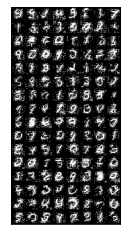

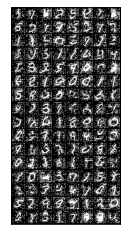

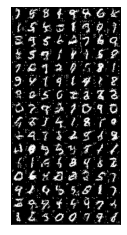

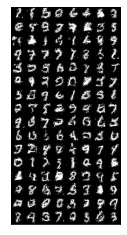

In [29]:
# loads MNIST into a big variable
data = MNISTDataModule()



data.prepare_data()
data.setup()

device = torch.device('cpu')

# collects all x in one tensor
first_time = True
for x, _ in data.train_dataloader():
    if first_time:
        big_mnist = x
        first_time = False
    else:
        big_mnist = torch.cat((big_mnist, x))

big_mnist = big_mnist.to(device)

#finds the index of the top3 numbers
def find_next_number(origin, dataset):    
    dist = dataset - origin.repeat((48000, 1, 1, 1))
    dist = torch.sum(dist, (1, 2, 3))**2 #Euclidean norm.?

    topk = torch.topk(dist, 3, largest=False)
    return topk[1]


def load_model_from_epsilon(epsilon: str):
    file_name = [model for model in listdir('models')
                 if f"_{epsilon}_" in model][0]
    
    model = DPGAN.load_from_checkpoint(f"models/{file_name}")
    return model
    

#irgendwo in dict speichern mit den Ergebnissen, damit sie aufgerufen werdne können
results_first_experiment = dict()
fixed_noise = torch.randn(model.batch_size, 100, 1, 1).to(device)
#sample = model(fixed_noise).to(device)




for epsilon in ["inf", "29.0", "14.0", "9.6"]: #(a) ϵ =∞
    model = load_model_from_epsilon(epsilon).to(device)

    sample = model(fixed_noise)
    
    sample_one_pic = list()

    for i in range(10):
        sample_one_pic.append(sample[i].to(device))


    grid = torch.clamp(make_grid(sample), min=0)
    grid = make_grid(sample)
    show(grid)
    topks = list()
    
    for i in range(10):
        topk = find_next_number(sample_one_pic[i], big_mnist)
        
        topks.append(topk)

    results_first_experiment[epsilon] = {
        "fixed_noise": fixed_noise, 
        "sample": sample,
        "topks": topks
    }
        
    

### Visualize the results

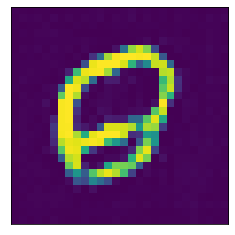

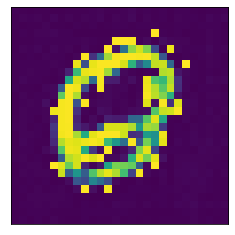

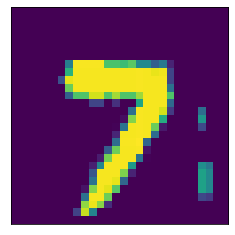

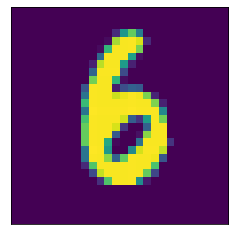

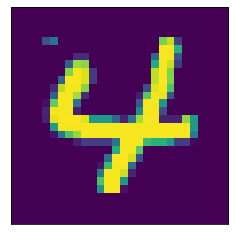

In [30]:
#change the parameter to change the output
epsilon = 'inf' #from ["inf", "29.0", "14.0", "9.6"]
i_sample = 3 # 0 <= i_sample <= 10



#now the code

topk = results_first_experiment[epsilon]['topks'][i_sample]

show(torch.clamp(sample_one_pic[i_sample], min=0))
show(sample_one_pic[i_sample])

for j in range(3):
    show(big_mnist[topk[j]])



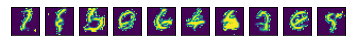

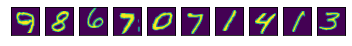

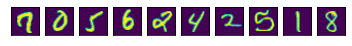

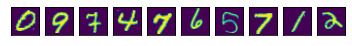

In [31]:
## similar to Chart 1

epsilon = 'inf' #from ["inf", "29.0", "14.0", "9.6"]
show(sample_one_pic)
topk = results_first_experiment[epsilon]['topks']

lines = list()

for i_line in range(3):
    new_line = list()
    for sample in topk:
        new_line.append(big_mnist[sample[i_line]])
    lines.append(new_line)
    
    
for line in lines:
    show(line)


## Classification on MNIST Data

Now we will try to check of the chapter 4.3
Here we create 4000 samples for different epsilon values and for a preselection of two digits, which we use for training binary classifiers.
It should become clear that with stronger data protection the performance on models can decrease.
The process is incompletely documented. However, my simple model can perform very well with the generated data. It's better than in the results of the paper.

### Preparing automated order

To be able to split large samples from the GAN in an automated way, we train a larger model. Code based on https://github.com/stabgan/CNN-classification-of-MNIST-dataset-using-pyTorch/blob/master/cnn.py 

In [5]:
class CNNModel(nn.Module):
    def __init__(self, classes=10):
        super(CNNModel, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(32 * 4 * 4, classes) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        # Max pool 1
        out = self.maxpool1(out)
        
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        
        # Max pool 2 
        out = self.maxpool2(out)
        
        # Resize
        # Original size: (100, 32, 7, 7)
        # out.size(0): 100
        # New out size: (100, 32*7*7)
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        
        return out

In [6]:
dm = MNISTDataModule('.', batch_size=128)
dm.prepare_data()
dm.setup()

/vol/fob-vol3/mi20/kralaben/miniconda3/envs/dpgan1/lib/python3.10/site-packages/pytorch_lightning/core/datamodule.py:88: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
/vol/fob-vol3/mi20/kralaben/miniconda3/envs/dpgan1/lib/python3.10/site-packages/pytorch_lightning/core/datamodule.py:107: LightningDeprecationWarning: DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7.
/vol/fob-vol3/mi20/kralaben/miniconda3/envs/dpgan1/lib/python3.10/site-packages/pytorch_lightning/core/datamodule.py:126: LightningDeprecationWarning: DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7.


In [7]:
def metrics(model, dataset, device):
    pred_labels = list()
    true_labels = list()
    for x, y in dataset:
        x = x.to(device)
        y = y.to(device)
        pred = torch.argmax(model(x), 1)
        pred_labels.append(pred)
        true_labels.append(y)
    pred_labels = torch.cat(pred_labels).cpu().detach().numpy()
    true_labels = torch.cat(true_labels).cpu().detach().numpy()


    return (
        f1_score(true_labels, pred_labels, average='macro'), 
        accuracy_score(true_labels, pred_labels), 
    )


In [8]:
model_mnist = CNNModel()

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model_mnist = CNNModel()
model_mnist = model_mnist.to(device)
learning_rate = 0.01

optimizer = torch.optim.SGD(model_mnist.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

i_iter = 0
for epoch in range(15):
    for images, labels in dm.train_dataloader():
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            # Forward pass to get output/logits
            outputs = model_mnist(images)

            # Calculate Loss: softmax --> cross entropy loss
            loss = criterion(outputs, labels)

            # Getting gradients w.r.t. parameters
            loss.backward()

            # Updating parameters
            optimizer.step()
            i_iter += 1 
            print(i_iter, end="\r")
    print(metrics(model_mnist, dm.val_dataloader(), device))

(0.8426764083276665, 0.84325)
(0.9017916681055811, 0.9028333333333334)
(0.9172210939903914, 0.918)
(0.9379426991250686, 0.9384166666666667)
(0.945062310733498, 0.9454166666666667)
(0.9555001750425566, 0.95575)
(0.9575274289635027, 0.9578333333333333)
(0.9615209096609896, 0.96175)
(0.9618318354236749, 0.9621666666666666)
(0.9665661465033898, 0.96675)
(0.9685592304971138, 0.96875)
(0.9690021351384169, 0.9690833333333333)
(0.970940425253659, 0.9710833333333333)
(0.9720939877691844, 0.97225)
(0.9724598971259345, 0.9725833333333334)


### Training the binary classifiers

In [9]:
#Simple One
class BinaryEasyModel(nn.Module):
    def __init__(self):
        super(BinaryEasyModel, self).__init__()

        self.mlp = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 2),
            nn.Sigmoid()
        )
    def forward(self, x):
        fl = torch.flatten(x, start_dim=1)
        out = self.mlp(fl)
        
        return out

In [10]:

def metrics2(model, dataset, device):
    pred_labels = list()
    true_labels = list()
    for x, y in dataset:
        x = x.to(device).detach()
        y = y.to(device).detach()
        #pdb.set_trace()
        pred = torch.argmax(model(x), 1)
        #pred = model(x)
        pred_labels.append(pred)
        
        true_labels.append(torch.argmax(y, 1))
    pred_labels = torch.cat(pred_labels).cpu().detach().numpy()
    true_labels = torch.cat(true_labels).cpu().detach().numpy()


    return (
        f1_score(true_labels, pred_labels, average='macro'), 
        accuracy_score(true_labels, pred_labels), 
    )

def load_model_from_epsilon(epsilon: str):
    file_name = [model for model in listdir('models')
                 if f"_{epsilon}_" in model][0]
    
    model = DPGAN.load_from_checkpoint(f"models/{file_name}")
    return model

In [13]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model_mnist = model_mnist.to(device)
results = dict()

for sampled_classes in [[0,1 ], [2, 3], [4, 5]]:
    for epsilon in ["11.5", "3.2", "0.96", "0.72"]:
        print(sampled_classes, epsilon)

        model = load_model_from_epsilon(epsilon)
        model = model.to(device)
        #create samples for binary training

        samples_1 = list()
        samples_2 = list()
        len_samples1 = 0
        len_samples2 = 0

        while len_samples1 < 2000 and len_samples2 < 2000:
            noise = torch.randn(model.batch_size, 100, 1, 1).to(device)
            unfiltered_samples = model(noise).to(device)    

            pred = torch.argmax(model_mnist(unfiltered_samples), 1)
            mask_element_1 = pred == sampled_classes[0]
            mask_element_2 = pred == sampled_classes[1]

            samples_1.append(unfiltered_samples[mask_element_1])
            samples_2.append(unfiltered_samples[mask_element_2])
            len_samples1 += unfiltered_samples[mask_element_1].shape[0]
            len_samples2 += unfiltered_samples[mask_element_2].shape[0]

        train_data1 = torch.cat(samples_1)[:2000]
        train_data2 = torch.cat(samples_2)[:2000]

        y1_train = torch.tensor([1., 0]).repeat(train_data1.shape[0], 1)
        y2_train = torch.tensor([0,  1.]).repeat(train_data2.shape[0], 1)


        train_data, train_y = torch.cat((train_data1, train_data2)).detach(), torch.cat((y1_train, y2_train)).detach(),
        
        test_data1 = list()
        test_data2 = list()

        #create test data

        for x, y in dm.test_dataloader():
            mask_element_1 = y == sampled_classes[0]
            mask_element_2 = y == sampled_classes[1]

            test_data1.append(x[mask_element_1])
            test_data2.append(x[mask_element_2])

        test_data1 = torch.cat(test_data1)
        test_data2 = torch.cat(test_data2)


        y1_test = torch.tensor([1., 0.]).repeat(test_data1.shape[0], 1)
        y2_test = torch.tensor([0., 1.]).repeat(test_data2.shape[0], 1)


        test_data, test_y = torch.cat((test_data1, test_data2)), torch.cat((y1_test, y2_test)),
        
        

                
        results[(epsilon, sampled_classes[0], sampled_classes[1])] = list()
        
        #trains the binary model 10 times
        for _ in range(10):
            binary_model = BinaryEasyModel()

            #device = torch.device('cpu')
            binary_model = binary_model.to(device)
            learning_rate = 0.01

            optimizer = torch.optim.SGD(binary_model.parameters(), lr=learning_rate)
            criterion = nn.CrossEntropyLoss()

            dl_binary_train = DataLoader(TensorDataset(train_data, train_y),  batch_size=128, shuffle=True)
            dl_binary_test = DataLoader(TensorDataset(test_data, test_y), batch_size=128, shuffle=True)

            
            #actuall training process
            for epoch in range(2):
                for images, labels in dl_binary_train:
                        optimizer.zero_grad()

                        images = images.to(device)
                        labels = labels.to(device)

                        # Forward pass to get output/logits
                        outputs = binary_model(images)

                        # Calculate Loss: softmax --> cross entropy loss
                        loss = criterion(outputs, labels)

                        # Getting gradients w.r.t. parameters
                        loss.backward()

                        # Updating parameters
                        optimizer.step()
                        optimizer.zero_grad()

                        i_iter += 1 
                        print(i_iter, end="\r")
                
            met = metrics2(binary_model, dl_binary_test, device)
            results[(epsilon, sampled_classes[0], sampled_classes[1])].append(met)
    
    
    

[0, 1] 11.5
[0, 1] 3.2
[0, 1] 0.96
[0, 1] 0.72
[2, 3] 11.5
[2, 3] 3.2
[2, 3] 0.96
[2, 3] 0.72
[4, 5] 11.5
[4, 5] 3.2
[4, 5] 0.96
[4, 5] 0.72


### Visualisize the results

In [14]:
#convert into dataframe
csv_list = list()
for epsilon, boundary1, boundary2 in results:
    for f1, acc in results[(epsilon, boundary1, boundary2)]:
        csv_list.append({
            "epsilon": epsilon if not "3.2" in epsilon else "03.2" ,
            "sample_class": (boundary1, boundary2),
            "accuracy": acc,
            "f1": f1
        })
        
csv_list = sorted(csv_list, key= lambda x: float(x['epsilon']))
df = pd.DataFrame(csv_list)

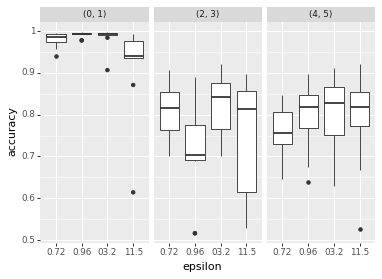

<ggplot: (8792163940737)>

In [15]:
(ggplot(df, aes(x='epsilon', y='accuracy'))
 + geom_boxplot()
 + facet_wrap('sample_class')
)

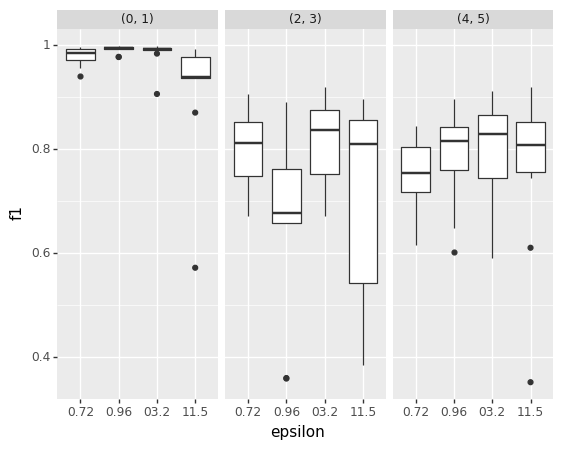

<ggplot: (8792378934035)>

In [16]:
(ggplot(df, aes('epsilon', 'f1'))
 + geom_boxplot()
 + facet_wrap('sample_class'))

# Conclusion

Unfortunately, the paper is not completely reproducible. 

The chapter 4.1 could not be reproduced because the DPGAN outputs too noisy data.
In the original paper, as a look at Figure 1 shows, additional transformations were performed.
However, they were not documented.

 I could not attenuate the model enough to reproduce the results documented in 4.3. This is especially
surprising, since I already use a simple model and still get very good results. Again, this shows a lack of documentation.
Difficult data sets could help(e.g. Fashion MNIST) to infer the statement from 4.3. after all. 

Nevertheless, training data created by the GAN is very good for training.
In conjunction with privacy guarantees, DPGAN is a step forward.





## Sources

- Dwork, Cynthia and Aaron Roth. “The Algorithmic Foundations of Differential Privacy.” Found. Trends Theor. Comput. Sci. 9 (2014): 211-407.
- Xie, Liyang et al. “Differentially Private Generative Adversarial Network.” ArXiv abs/1802.06739 (2018): n. pag.
- Heaven,`Will Douglas "AI is wrestling with a replication crisis" MIT Technologie Review (2020)
- Hutson, Matthew "Artificial intelligence faces reproducibility crisis" Science (2018):Vol 359, Issue 6377 pp. 725-726
- Arjovsky, Martín et al. “Wasserstein Generative Adversarial Networks.” ICML (2017).